In [1]:
import folium
#find spark
import findspark
findspark.init()
 
#create pyspark context
import pyspark
sc = pyspark.SparkContext(appName="AppName")
 
#create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

from pyspark.sql.types import StringType, IntegerType
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.dates as mdates
from pyspark.sql.functions import split, concat_ws, col, lit
from pyspark.sql.functions import max as sparkMax
from pyspark.sql import functions as F 

# Probleemstelling

In dit project onderzoek ik of de tweets die Elon Musk plaatste op Twitter impact hadden op de beurswaarde van Tesla.
Ik heb een dataset gevonden van de Tesla beurswaarden van 2010-06-29 tot 2023-11-21.
Ook heb ik een opgesplitste dataset gevonden van alle tweets die Elon heeft geplaatst van 2010-06-04 tot 2022-03-05 die verdeelt is in 1 dataset per jaar.

In [2]:
#importing alle tweet datasets



tweets_10 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2010.csv")
tweets_11 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2011.csv")
tweets_12 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2012.csv")
tweets_13 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2013.csv")
tweets_14 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2014.csv")
tweets_15 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2015.csv")
tweets_16 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2016.csv")
tweets_17 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2017.csv")
tweets_18 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2018.csv")
tweets_19 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2019.csv")
tweets_20 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2020.csv")
tweets_21 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2021.csv")
tweets_22 = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("2022.csv")

tweetlist = [tweets_10, tweets_11, tweets_12, tweets_13, tweets_14, tweets_15, tweets_16, tweets_17, tweets_18, tweets_19, tweets_20, tweets_21, tweets_22]



## Data transformation/preprocessing

Ik print de hoeveelheid kolommen van elke dataset om te zien of ze gelijk zijn.

In [3]:
#checken of alle datasets even veel kolommen hebben (spoiler alert: niet het geval)
for tweets in tweetlist:
    colss = len(tweets.columns)
    print(colss)

39
39
39
39
39
39
39
39
39
39
39
36
36


Dit is niet het geval, wel is er te zien dat enkel de laatste 2 datasets anders zijn.

Ik ga de kolomnamen van derde laatste en voorlaatste kolommen vergelijken om te bekijken welke kolommen er ontbreken of anders noemen in de laatste 2 datasets.

In [4]:
#kijken welke kolommen ontbreken of anders noemen
colnames_21 = tweetlist[11].columns
colnames_20 = tweetlist[10].columns

result = [name for name in colnames_20]
for name in colnames_20:
    if name in colnames_21:
        result.remove(name)
print(result)

result = [name for name in colnames_21]
for name in colnames_21:
    if name in colnames_20:
        result.remove(name)
print(result)

['_c0', 'user_id_str', 'day', 'hour', 'nlikes', 'nreplies', 'nretweets', 'search']
['time', 'mentions', 'replies_count', 'retweets_count', 'likes_count']


We zien hier dat kolommen _c0, user_id_str, day, hour en search niet bestaan in datasets van jaren na 2021. en dat kolommen time en mensions niet bestaan in datasets voor 2021.
Ook nemen we aan dat replies_count, retweets_count en likes_count gelijk zijn aan respectievelijk nreplies, nretweets, nlikes.

In [5]:
#fixing it
count = 0
for tweets in tweetlist:
    tweetlist[count] = tweets.drop('day', 'hour', '_c0', 'search', 'mentions', 'user_id_str')
    count += 1
count = 11
for tweets in tweetlist:   
    tweetlist[count] = tweetlist[count].withColumnRenamed('likes_count','nlikes')
    tweetlist[count] = tweetlist[count].withColumnRenamed('replies_count','nreplies')
    tweetlist[count] = tweetlist[count].withColumnRenamed('retweets_count','nretweets')
    if (count == 12):
        break
    count += 1
    
    
    
#kijken welke kolommen ontbreken of anders noemen
colnames_21 = tweetlist[11].columns
colnames_20 = tweetlist[10].columns

result = [name for name in colnames_20]
for name in colnames_20:
    if name in colnames_21:
        result.remove(name)
print(result)

result = [name for name in colnames_21]
for name in colnames_21:
    if name in colnames_20:
        result.remove(name)
print(result)

[]
['time']


Er schiet nog 1 kolom over die niet gelijk is in elke dataFrame is time, omdat ik die nog nodig heb. De kolom date heeft namelijk een ander formaat voor 2021. Gelukkig is dit op te lossen door kolommen date en time samen te voegen.

Daarna selecteer ik in elke dataset de 4 kolommen die ik nodig heb om de impact van de tweets te bekijken. dit zijn kolommen "date", "nlikes", "nreplies" en "nretweets".

In [6]:
count = 11
for tweets in tweetlist:
    # Split 'created_at' column by space to separate date and time

    # Concatenate the first two elements of the split array to form a new column 'date_time'
    tweetlist[count] = tweetlist[count].withColumn("date", concat_ws(" ", col("date").cast(StringType()), col("time").cast(StringType())))

    # tweetlist[count].show(1)
    if (count == 12):
        break
    count += 1
    
    
count = 0
for tweets in tweetlist:
    tweetlist[count] = tweetlist[count].drop('time')
    tweetlist[count] = tweetlist[count].select(col("date"), col("nlikes"), col("nreplies"), col("nretweets"))
    tweetlist[count].show(1)
    if (count == 12):
        break
    count += 1
    

+-------------------+------+--------+---------+
|               date|nlikes|nreplies|nretweets|
+-------------------+------+--------+---------+
|2010-06-04 18:31:57|  4652|     391|      348|
+-------------------+------+--------+---------+

+-------------------+------+--------+---------+
|               date|nlikes|nreplies|nretweets|
+-------------------+------+--------+---------+
|2011-12-28 22:27:08|    12|       7|        1|
+-------------------+------+--------+---------+
only showing top 1 row

+-------------------+------+--------+---------+
|               date|nlikes|nreplies|nretweets|
+-------------------+------+--------+---------+
|2012-12-25 22:37:56|     4|       5|        2|
+-------------------+------+--------+---------+
only showing top 1 row

+-------------------+------+--------+---------+
|               date|nlikes|nreplies|nretweets|
+-------------------+------+--------+---------+
|2013-12-26 21:06:38|    14|      31|        4|
+-------------------+------+--------+--

Ik voer nog een controle uit door van elke dataset 1 rij te printen en dezelfde code om de kolomnamen te vergelijken opnieuw uit te voeren.

In [7]:
# Show the updated DataFrame (tweets_22)
colnames_21 = tweetlist[11].columns
colnames_20 = tweetlist[10].columns

result = [name for name in colnames_20]
for name in colnames_20:
    if name in colnames_21:
        result.remove(name)
print(result)
result = [name for name in colnames_21]
for name in colnames_21:
    if name in colnames_20:
        result.remove(name)
print(result)

[]
[]


Er is te zien dat er geen verchillen meer zijn in de datasets dus we kunnen ze allemaal samenvoegen tot 1 grote dataset.

In [8]:
#union naar 1 grote dataset
count = 0
for tweets in tweetlist:
    if  tweetlist[0] == tweetlist[count]:
        all_tweets = tweetlist[count]
    else:
        all_tweets = all_tweets.union(tweetlist[count])
    count +=1

Daarna cast ik alle numerieke waarden naar een int en de dateum -die ik hernoem naar postdate- cast ik naar een string.

In [9]:
all_tweets = all_tweets.withColumnRenamed("date", "postdate")
all_tweets = all_tweets.withColumn("postdate", col("postdate").cast(StringType()))
all_tweets = all_tweets.withColumn("nlikes", col("nlikes").cast("int"))
all_tweets = all_tweets.withColumn("nretweets", col("nretweets").cast("int"))
all_tweets = all_tweets.withColumn("nreplies", col("nreplies").cast("int"))

In [10]:
rdd_all_tweets = all_tweets.rdd

# Data visualisatie

Om de data te visualiseren zal ik gebruik maken van widgets en plots

In [11]:
w_year = widgets.Dropdown(
    options=['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
    value='2017',
    description='Year: ',
    disabled=False,
)

keuze = widgets.Dropdown(
    options=['Likes', 'Replies', 'Retweets'],
    value='Likes',
    description='Pick Graph: ',
    disabled=False,
)
display(w_year)
display(keuze)

Dropdown(description='Year: ', index=7, options=('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017…

Dropdown(description='Pick Graph: ', options=('Likes', 'Replies', 'Retweets'), value='Likes')

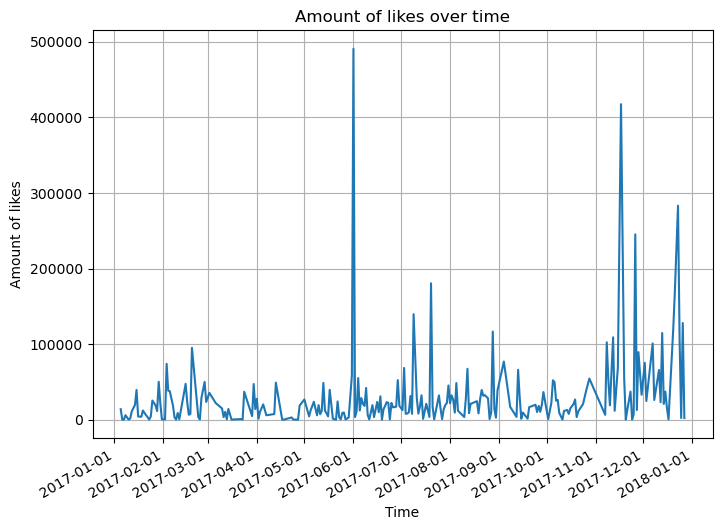

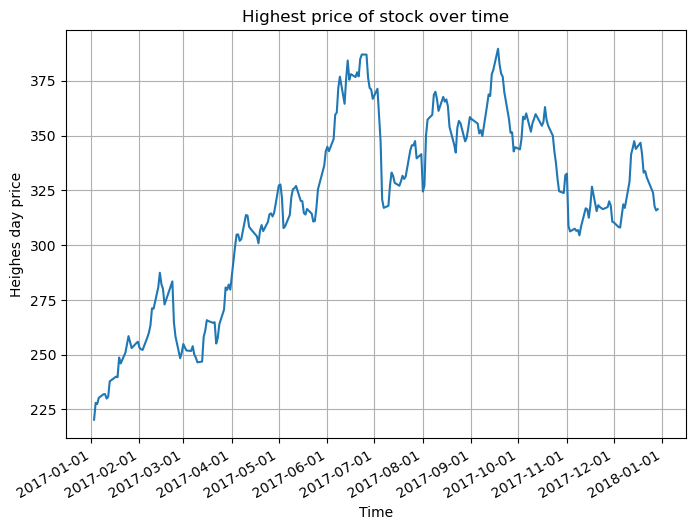

In [12]:
to_filter = all_tweets.withColumn('postdate',  split(col('postdate'), ' ')[0])
to_filter = to_filter.groupBy(col("postdate")).agg(
    sparkMax(col("nlikes")).alias("max_nlikes"),
    sparkMax(col("nreplies")).alias("max_nreplies"),
    sparkMax(col("nretweets")).alias("max_nretweets")
)
to_filter = to_filter.select(col('postdate'), col('max_nlikes'), col('max_nreplies'), col('max_nretweets'))

to_filter = to_filter.withColumn('yearchosen',  lit(w_year.value))

to_filter.createOrReplaceTempView('to_filter_tempview')

query = """
SELECT
*
FROM
to_filter_tempview
WHERE
YEAR(postdate) = yearchosen
ORDER BY postdate
"""

filtered_tweets = spark.sql(query)

x_values = filtered_tweets.rdd.map(lambda x: x['postdate']).collect()

y_values_likes = filtered_tweets.rdd.map(lambda x: x['max_nlikes'])
y_values_replies = filtered_tweets.rdd.map(lambda x: x['max_nreplies'])
y_values_retweets = filtered_tweets.rdd.map(lambda x: x['max_nretweets'])

if keuze.value == "Likes":
    choice = y_values_likes
    label = "Amount of likes"
    
elif keuze.value == "Replies":
    choice = y_values_replies
    label = "Amount of replies"
    
elif keuze.value == "Retweets":
    choice = y_values_retweets
    label = "Amount of retweets"
    
y_values = choice.collect()

# Plotting the line graph
plt.figure(figsize=(8, 6))
x_values= [mdates.datestr2num(i) for i in x_values]
plt.plot(x_values, y_values, marker='', linestyle = '-')
plt.xlabel('Time')
plt.ylabel(label)
plt.title(label + ' over time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gcf().autofmt_xdate() 

plt.show()


#stock plot

tesla_stock_dataframe = spark.read.format('csv').option('header', 'true').option("delimiter", ",").load("tsla_raw_data.csv")
tesla_stock_dataframe = tesla_stock_dataframe.withColumn('yearchosen',  lit(w_year.value))
tesla_stock_dataframe = tesla_stock_dataframe.withColumnRenamed('date',  'postdate')
rdd_tesla = tesla_stock_dataframe.rdd

tesla_stock_dataframe.createOrReplaceTempView('tesla_tempview')

query = """
SELECT
*
FROM
tesla_tempview
WHERE
YEAR(postdate) = yearchosen
ORDER BY postdate
"""

filtered_tweets = spark.sql(query)

x_values = filtered_tweets.rdd.map(lambda row: row[0]).collect()
y_values = filtered_tweets.rdd.map(lambda row: float(row[2])).collect()

# Plotting the line graph
plt.figure(figsize=(8, 6))
x_values= [mdates.datestr2num(i) for i in x_values]
plt.plot(x_values, y_values, marker='', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Heighes day price')
plt.title('Highest price of stock over time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gcf().autofmt_xdate() 

plt.show()


We zien hier dat elon veel meer is beginnen tweeten vanaf 2017.

Maart 2020 heeft Elon Musk een tweet gemaakt: "the coronavirus pandemic is dumb" waarna de tesla stock heeft gestegen tot een hoogtepunt van $2250 waarna de prijs bijna 500% verminderd is omdat enkele fabrieken gestopt waren.

Niet zichtbaar op de grafieken maar op 11-08-2018 plaatste Elon Musk de tweet "tesla stock price is too high imo" waarna er na enkele uren een daling was van 10%.

Soms zijn er populaire tweets net voor een grote stijging zonder dat de tweet erg controverciëel is, zoals deze op 10-10-2018. Waarna ook een grote stijging volgde.

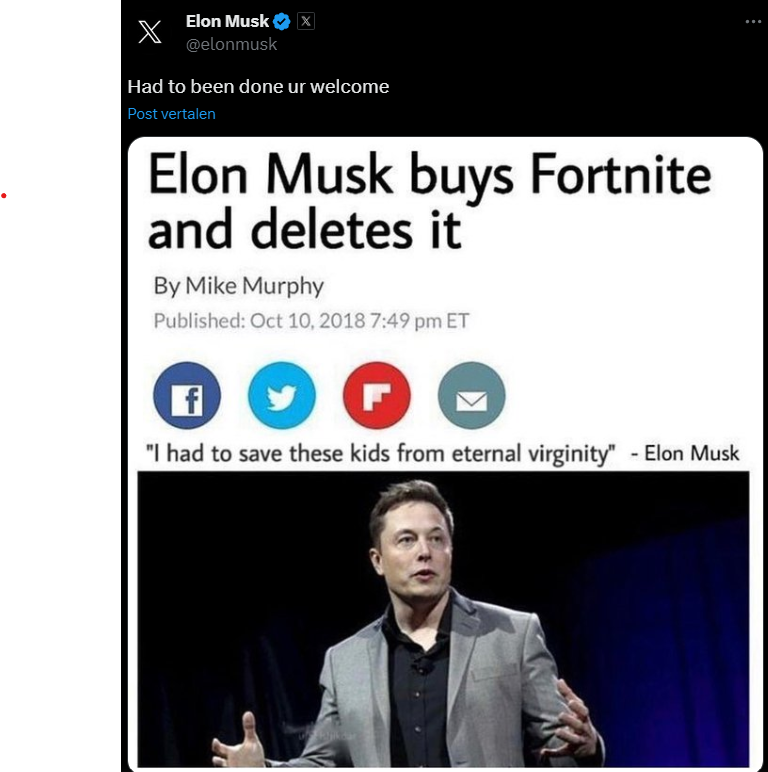

# Besluit

Bijna alle populaire tweets hebben een impact op de beurswaarde van Tesla, meestal hebben de tweets die zowel veel likes als veel reetweets hebben, de grootste impact.

# lessons learned

Datasets kunnen erg rot zijn om mee te werken.

Het is slim om variabelen geen namen te geven die overeenkomen met systeemvariabelen.

Selecteer best op voorhand de kolommen die je nodig hebt zodat je minder data moet aanpassen.